# FINAL MODELS ON TEST SETS AND EDA
---
---

# Table of Contents
---
### [Sources ](#Sources)
### [Imports ](#Imports)
### [Average Model Predictions](#Average-Predictions)
### [High Model Predictions](#High-Predictions)
### [Heart Rate Intensity Zones](#Intensity-Zones)
### [Adding Headwind](#Headwind)
### [Plot Drafting](#Plot-Drafting---Finals-in-Tableau)
### [Heatmaps](#Heatmaps!)

# Sources
---

In [1]:
# https://www.mayoclinic.org/healthy-lifestyle/fitness/in-depth/exercise-intensity/art-20046887
# https://www.garmin.com/en-US/blog/general/get-zone-train-using-heart-rate/
# https://mediawiki.ivao.aero/index.php?title=Crosswind_and_Headwind_calculation

# Imports
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter("ignore")

import pickle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
a_df = pd.read_csv('../data/a_test_df.csv')
h_df = pd.read_csv('../data/h_test_df.csv')

In [4]:
with open('../models/a_model_xgb.pkl', 'rb') as m:
    a_model = pickle.load(m)
    
with open('../models/h_model_xgb.pkl', 'rb') as m2:
    h_model = pickle.load(m2)

In [5]:
features = ['elevation', 'bearing', 'time_diff_s', 'total_time_s', 'ele_diff_m',
       'total_ele_change_m', 'dist_diff_km', 'total_dist_km',
       'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds',
       'wind_speed', 'wind_deg']

# Average Predictions
---

In [6]:
a_X = a_df[features]
a_preds = a_model.predict(a_X)

In [7]:
a_df['hr_preds'] = a_preds
a_df['hr_preds'].describe()

count    2849.000000
mean      138.012238
std         7.939801
min        68.934532
25%       133.313080
50%       138.932953
75%       143.628601
max       162.217361
Name: hr_preds, dtype: float64

# High Predictions
---

In [8]:
h_X = h_df[features]

# Standard Scaler preprocessing
h_ss = StandardScaler()
h_X_sc = h_ss.fit_transform(h_X)

# Polynomial Features preprocessing
h_poly = PolynomialFeatures()
h_X_p = h_poly.fit_transform(h_X_sc)

h_preds = h_model.predict(h_X_p)

In [9]:
h_df['hr_preds'] = h_preds
h_df['hr_preds'].describe()

count    2849.000000
mean      123.777725
std        19.454283
min        60.672554
25%       110.960175
50%       125.274506
75%       136.539581
max       186.485245
Name: hr_preds, dtype: float64

# Combine DFs
---

In [10]:
ah_df = pd.concat([a_df, h_df])

# Intensity Zones
---

In [11]:
# threshold and resting heart rate
thresh_hr = 220 - 33
rest_hr = 44

# heart rate reserve
hrr = thresh_hr - rest_hr

# target zones (5 zones - from garmin article)
hr_z1 = .7*thresh_hr
hr_z2 = .8*thresh_hr
hr_z3 = .9*thresh_hr
hr_z4 = 1*thresh_hr
hr_z5 = 1.1*thresh_hr
print(hr_z1, hr_z5, thresh_hr)

130.9 205.70000000000002 187


## Average DF Intensity

In [12]:
a_df['intensity'] = [1 if hr < hr_z1 
                     else 2 if (hr < hr_z2 and hr >= hr_z1)
                     else 3 if (hr < hr_z3 and hr >= hr_z2)
                     else 4 if (hr < hr_z4 and hr >= hr_z3)
                     else 5 
                     for hr in a_df['hr_preds']]

In [13]:
a_df.head()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km,time_diff_s,total_time_s,dt,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,datetime,hr_preds,intensity
0,38.11272,-122.65319,63.04,0.000000,0.00,0.00,"(38.11272, -122.65319000000001)",0.0000,0.0000,0.000000,0.000000,1659794400,289.02,288.93,1016,87,286.86,100,1.54,230,2022-08-06 07:00:00,162.217361,3
1,38.11343,-122.65308,63.40,6.978612,0.36,0.36,"(38.11343, -122.65308000000002)",0.0795,0.0795,4.615186,4.615186,1659794404,289.02,288.93,1016,87,286.86,100,1.54,230,2022-08-06 07:00:04,149.309937,2
2,38.11370,-122.65309,63.68,-1.676102,0.28,0.64,"(38.1137, -122.65309)",0.0300,0.1095,4.615186,9.230372,1659794409,289.02,288.93,1016,87,286.86,100,1.54,230,2022-08-06 07:00:09,141.379440,2
3,38.11425,-122.65358,64.76,-35.140713,1.08,1.72,"(38.114250000000006, -122.65358)",0.0747,0.1842,4.615186,13.845558,1659794413,289.01,288.92,1016,87,286.85,100,1.54,230,2022-08-06 07:00:13,139.252975,2
4,38.11461,-122.65354,65.55,5.016818,0.79,2.51,"(38.114610000000006, -122.65354)",0.0402,0.2244,4.615186,18.460743,1659794418,288.88,288.78,1016,87,286.72,100,1.54,230,2022-08-06 07:00:18,143.390732,2


In [14]:
a_df['intensity'].value_counts()

2    2228
1     534
3      87
Name: intensity, dtype: int64

## High DF Intensity

In [15]:
h_df['intensity'] = [1 if hr < hr_z1 
                     else 2 if (hr < hr_z2 and hr >= hr_z1)
                     else 3 if (hr < hr_z3 and hr >= hr_z2)
                     else 4 if (hr < hr_z4 and hr >= hr_z3)
                     else 5 
                     for hr in h_df['hr_preds']]

In [16]:
h_df.head()

,latitude,longitude,elevation,bearing,ele_diff_m,total_ele_change_m,lat_lon,dist_diff_km,total_dist_km,time_diff_s,total_time_s,dt,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,datetime,hr_preds,intensity
0,38.11272,-122.65319,63.04,0.000000,0.00,0.00,"(38.11272, -122.65319000000001)",0.0000,0.0000,0.000000,0.000000,1659794400,289.02,288.93,1016,87,286.86,100,1.54,230,2022-08-06 07:00:00,133.734512,2
1,38.11343,-122.65308,63.40,6.978612,0.36,0.36,"(38.11343, -122.65308000000002)",0.0795,0.0795,4.248005,4.248005,1659794404,289.02,288.93,1016,87,286.86,100,1.54,230,2022-08-06 07:00:04,122.218712,1
2,38.11370,-122.65309,63.68,-1.676102,0.28,0.64,"(38.1137, -122.65309)",0.0300,0.1095,4.248005,8.496010,1659794408,289.02,288.93,1016,87,286.86,100,1.54,230,2022-08-06 07:00:08,119.954750,1
3,38.11425,-122.65358,64.76,-35.140713,1.08,1.72,"(38.114250000000006, -122.65358)",0.0747,0.1842,4.248005,12.744016,1659794412,289.01,288.92,1016,87,286.85,100,1.54,230,2022-08-06 07:00:12,131.175461,2
4,38.11461,-122.65354,65.55,5.016818,0.79,2.51,"(38.114610000000006, -122.65354)",0.0402,0.2244,4.248005,16.992021,1659794416,288.88,288.78,1016,87,286.72,100,1.54,230,2022-08-06 07:00:16,123.618896,1


In [17]:
h_df['intensity'].value_counts()

1    1790
2     821
3     218
4      20
Name: intensity, dtype: int64

# Headwind
---

In [18]:
# add alpha and headwind columns to a_df
a_df['alpha'] = a_df['wind_deg'] - a_df['bearing']
a_df['headwind'] = [1 if alpha > -90 and alpha < 90 else 0 for alpha in a_df['alpha']]

In [19]:
# add alpha and headwind columns to h_df
h_df['alpha'] = h_df['wind_deg'] - h_df['bearing']
h_df['headwind'] = [1 if alpha > -90 and alpha < 90 else 0 for alpha in h_df['alpha']]

In [20]:
# add alpha and headwind columns to ah_df
ah_df['alpha'] = ah_df['wind_deg'] - ah_df['bearing']
ah_df['headwind'] = [1 if alpha > -90 and alpha < 90 else 0 for alpha in ah_df['alpha']]

# Plot Drafting - Finals in Tableau
---

<Figure size 1152x576 with 0 Axes>

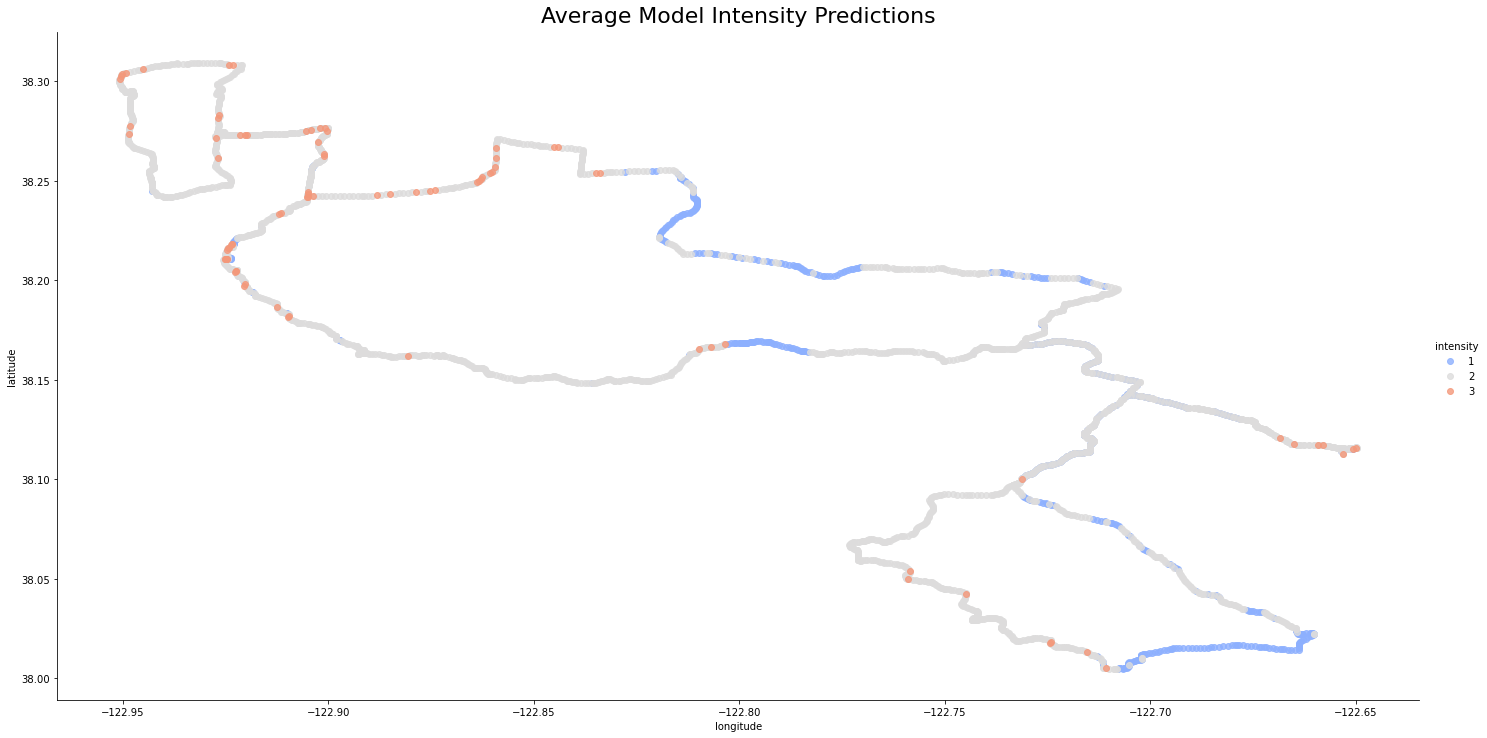

In [21]:
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=a_df, fit_reg=False, 
           hue='intensity', 
           palette = 'coolwarm', 
           height = 10, aspect = 2, legend = True)

plt.title('Average Model Intensity Predictions', pad = 10, fontsize = 22)

plt.show();

<Figure size 1152x576 with 0 Axes>

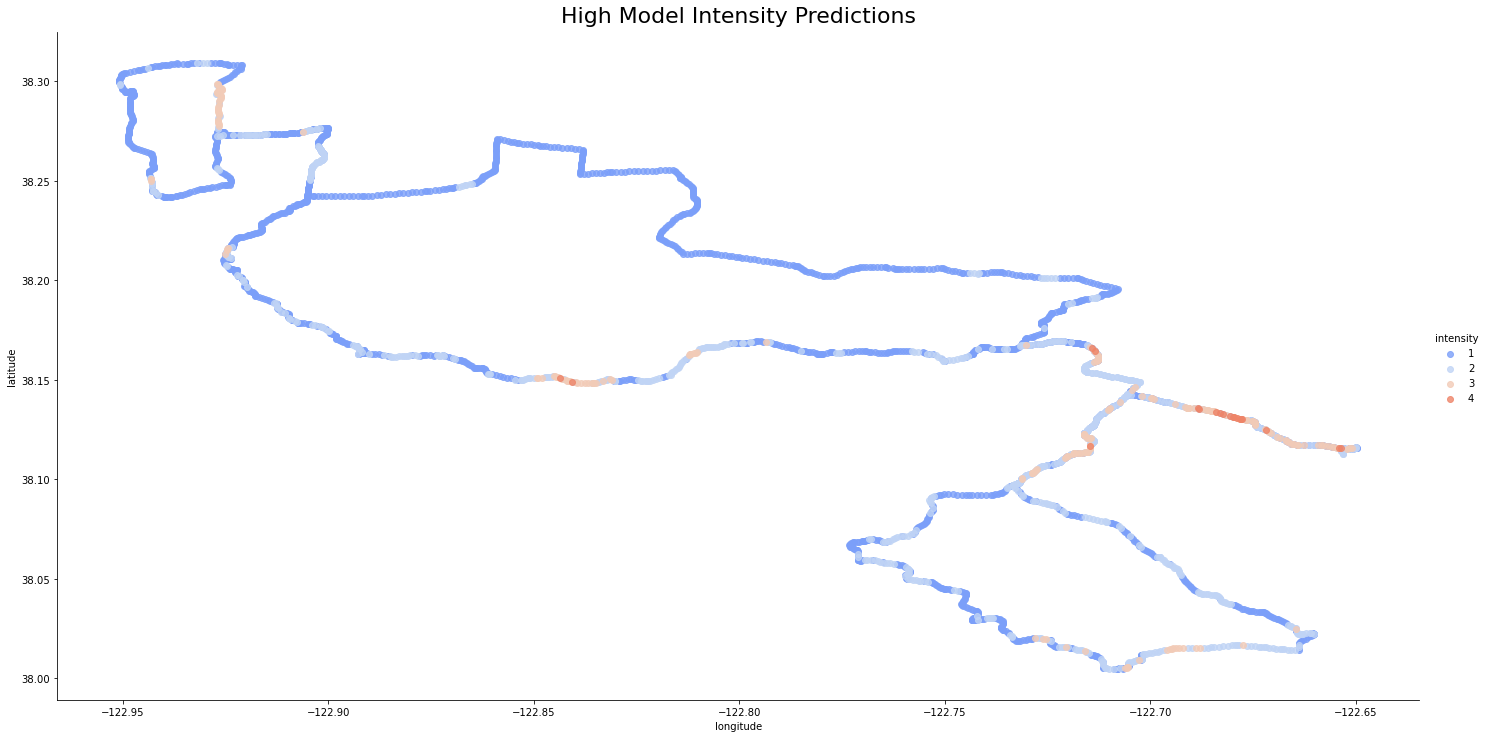

In [22]:
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=h_df, fit_reg=False, 
           hue='intensity', 
           palette = 'coolwarm', 
           height = 10, aspect = 2, legend = True)

plt.title('High Model Intensity Predictions', pad = 10, fontsize = 22)

plt.show();

## Elevation Drafting w/ Average

In [ ]:
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=a_df, fit_reg=False, 
           hue='ele_diff_m', 
           palette = 'coolwarm', 
           height = 10, aspect = 2, legend = False)

plt.show();

In [ ]:
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=a_df, fit_reg=False, 
           hue='elevation', 
           palette = 'coolwarm', 
           height = 10, aspect = 2, legend = False)

plt.show();

## Headwind Drafting w/ Average

In [ ]:
plt.figure(figsize = (16, 8))
sns.lmplot( x="longitude", y="latitude", data=a_df, fit_reg=False, 
           hue='headwind', 
           palette = 'coolwarm', 
           height = 10, aspect = 2, legend = False)

plt.show();

# Heatmaps!
---
Not a lot of significant correlations. I was surprised to see that headwind and elevation changes wouldn't have stronger correlations. 

In [ ]:
hr_corr = ah_df.corr()[['hr_preds']].sort_values(by = 'hr_preds', ascending = False)

plt.figure(figsize = (4, 10))

sns.heatmap(hr_corr,
           cmap = 'coolwarm',
           annot = True,
           vmin = -1,
           vmax = 1);

In [ ]:
# This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html

# Establish size of figure.
plt.figure(figsize = (16, 9))

# Get correlation of variables.
corr = round(ah_df.corr(), 2)

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr,
           mask = mask,
           square = True,
           cmap = 'coolwarm', # coolwarm and viridis are good for color blindness
           annot = True,
           vmin = -1,
           vmax = 1);

# Save CSVs

In [ ]:
a_df['datetime'] = a_df['dt'].apply(lambda x: datetime.fromtimestamp(x))
h_df['datetime'] = h_df['dt'].apply(lambda x: datetime.fromtimestamp(x))
ah_df['datetime'] = ah_df['dt'].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
# a_df.to_csv('../data/a_pred_df.csv', index = False)
# h_df.to_csv('../data/h_pred_df.csv', index = False)
# ah_df.to_csv('../data/ah_pred_df.csv', index = False)